In [1]:
from fastai.vision.all import *

In [2]:
# path to base folder 
path = Path('/mnt/2TB Working/Projects/Otoliths/v2')
# image folder path
image_path = path/'500px images'
# label csv path
label_path = path/'ages for nick.csv'
# model file name
model_name = path/'resnet_18_500px'

In [3]:
# batch size this is limited by the GPU memory
batch_size = 100
# size of your images
img_size = 500
# your desired model type, probibly one of these resnet18, resnet34, resnet50, resnet101, resnet152
model_type = resnet18

In [4]:
# get a list of image file names
image_paths = get_image_files(image_path)
file_names = []
for i in image_paths:
    file_names.append(os.path.basename(i))

In [5]:
# open the label file are a pandas dataframe and filter it by the image list
labels = pd.read_csv(label_path)
labels = labels[labels['Image_name'].isin(file_names)]
labels.head()

Image_name   Age
1   AH13-2352.jpg  4.83
4   AH13-0507.jpg  4.92
6   AH11-0776.jpg  4.75
10  AH13-2227.jpg  4.83
11  AH12-1818.jpg  4.75

In [6]:
item_tfms = []#Resize(img_size)
batch_tfms = [*aug_transforms(size=img_size, max_rotate=10.0,max_warp=0),Normalize.from_stats(*imagenet_stats)]

In [7]:
# make a fastai databunch using the labels and the images, also apply some augmentations 
# https://docs.fast.ai/vision.augment.html#aug_transforms
data = ImageDataLoaders.from_df(df = labels, path = image_path, seed = 42, 
                                bs = batch_size,y_block = RegressionBlock,
                                batch_tfms = batch_tfms,
                                item_tfms = item_tfms
                               )

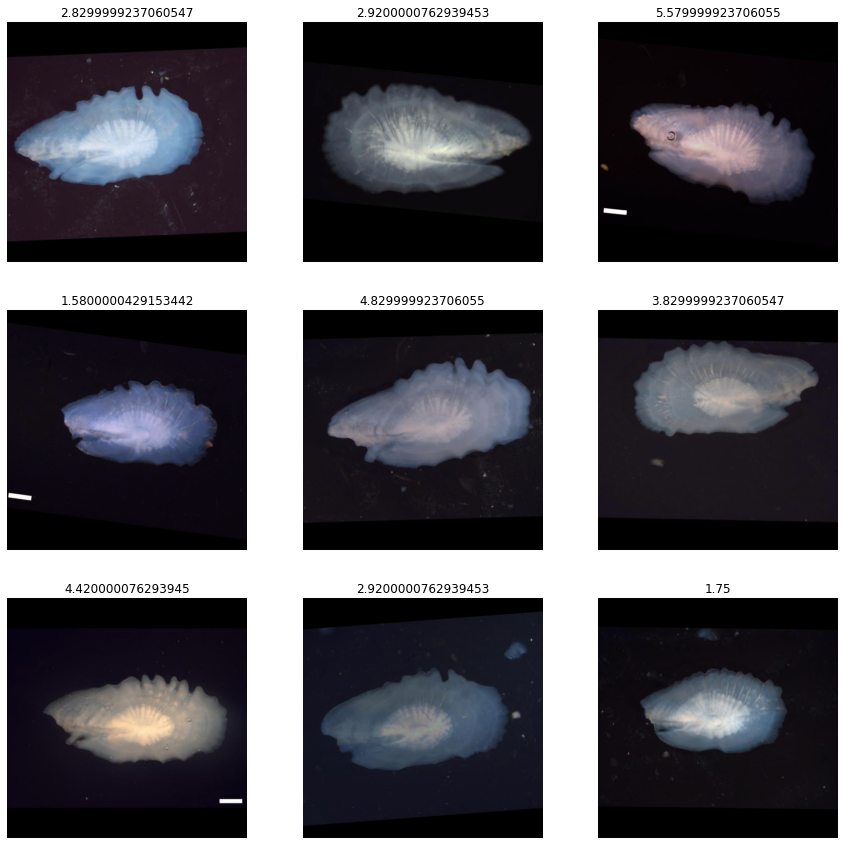

In [8]:
# show some data
data.show_batch(max_n = 9, figsize = (15,15))

In [9]:
# define an easily understandable metric
def mean_abs_error(pred,targ):
    "Mean absolute error between `pred` and `targ`."
    pred,targ = flatten_check(pred,targ)
    return torch.abs(pred - targ).mean()

In [10]:
learn = cnn_learner(data, resnet18, metrics=mean_abs_error).to_fp16()

In [11]:
learn.fine_tune?

Better model found at epoch 0 with mean_abs_error value: 3.063559055328369.


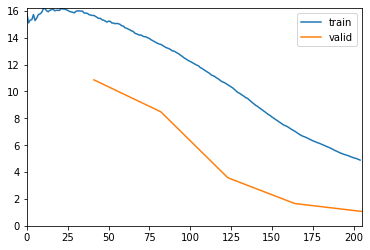

Better model found at epoch 1 with mean_abs_error value: 2.700632333755493.
Better model found at epoch 2 with mean_abs_error value: 1.5779778957366943.
Better model found at epoch 3 with mean_abs_error value: 1.0017447471618652.
Better model found at epoch 4 with mean_abs_error value: 0.7981612086296082.


Better model found at epoch 0 with mean_abs_error value: 0.7069956064224243.


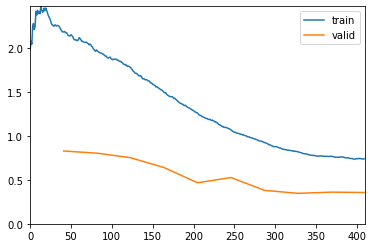

Better model found at epoch 1 with mean_abs_error value: 0.6802303791046143.
Better model found at epoch 2 with mean_abs_error value: 0.6669381856918335.
Better model found at epoch 3 with mean_abs_error value: 0.6019876003265381.
Better model found at epoch 4 with mean_abs_error value: 0.5159525871276855.
Better model found at epoch 6 with mean_abs_error value: 0.45911577343940735.
Better model found at epoch 7 with mean_abs_error value: 0.43725115060806274.


In [12]:
learn.fine_tune(epochs = 20, freeze_epochs = 5,cbs = [ShowGraphCallback(), SaveModelCallback(monitor='mean_abs_error',
                                                                with_opt=True,  fname=model_name)])

In [13]:
# reload the best model
learn.load(model_name)
learn.export(str(model_name)+'.pkl')

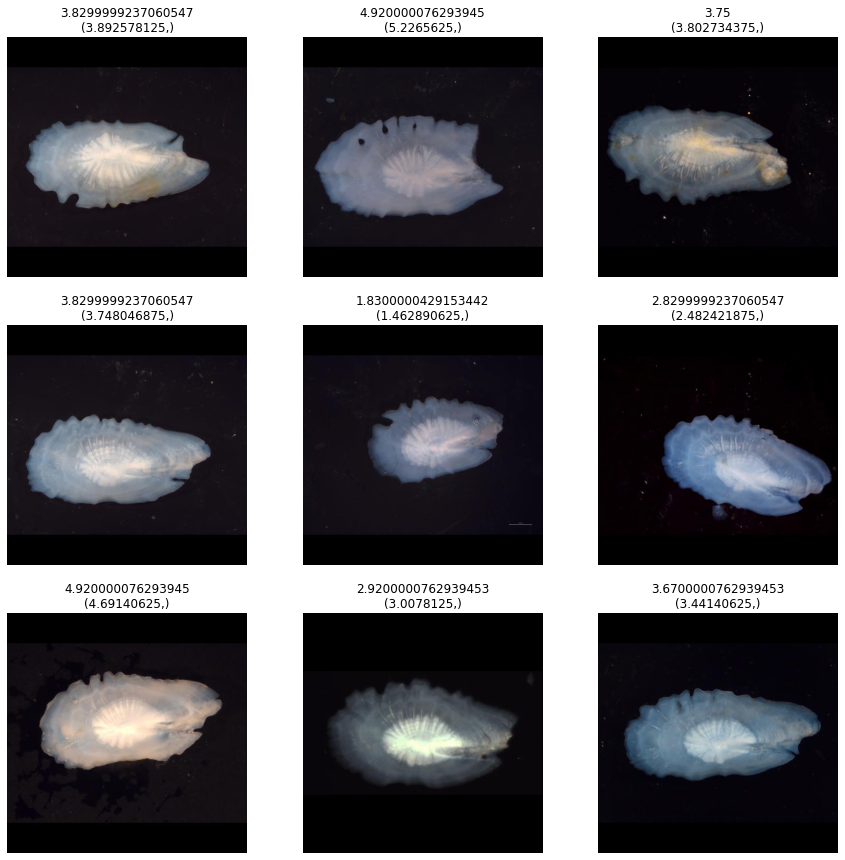

In [14]:
learn.show_results(max_n = 9, figsize = (15,15))

In [15]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [16]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [17]:
for batch,labels in data[0]:

    with Hook(learn.model[0]) as hook:
        with torch.no_grad(): output = learn.model.eval().cuda()(batch)
        act = hook.stored
    
    with HookBwd(learn.model[0]) as hookg:
        with Hook(learn.model[0]) as hook:
            output = learn.model.eval()(batch)
            
            act = hook.stored

        output.sum(0).backward()

        grad = hookg.stored
    
    w = grad.mean(dim=[2,3], keepdim=True)
    cam_map = (w * act).sum(1)
    

    break

<ipython-input-18-300cc26b546b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _,ax = plt.subplots()


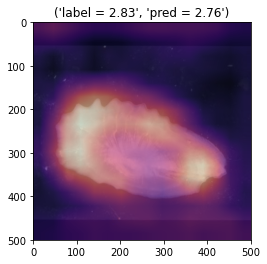

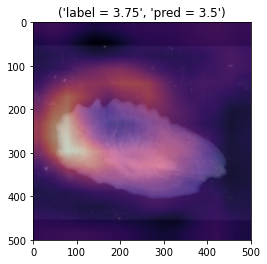

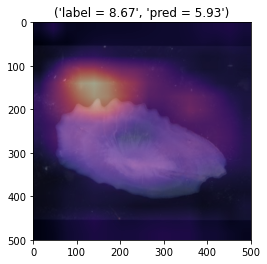

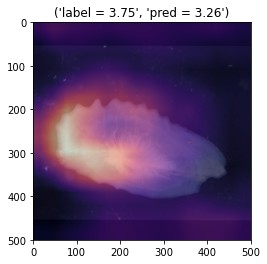

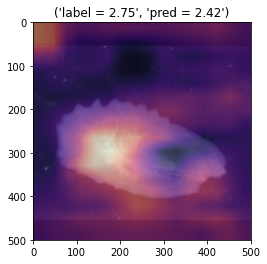

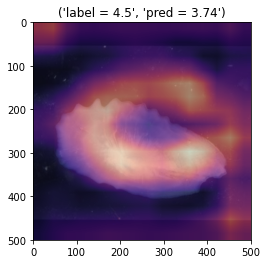

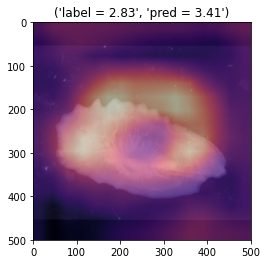

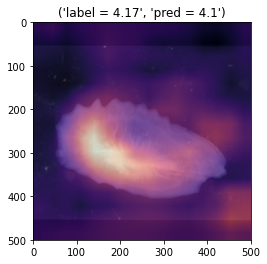

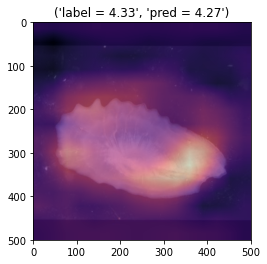

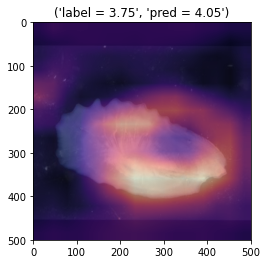

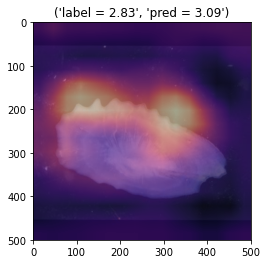

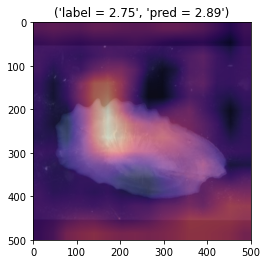

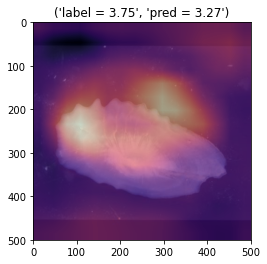

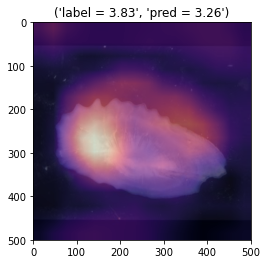

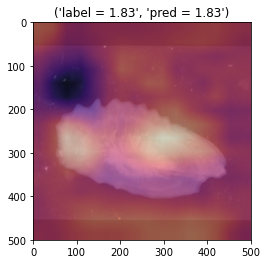

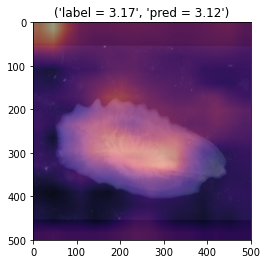

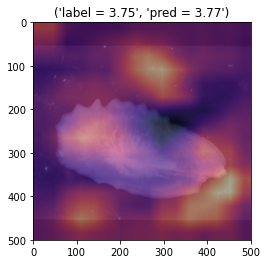

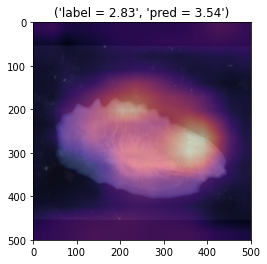

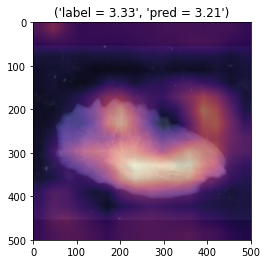

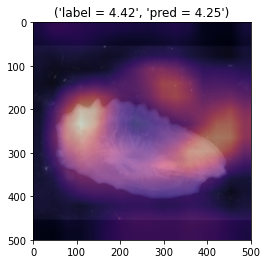

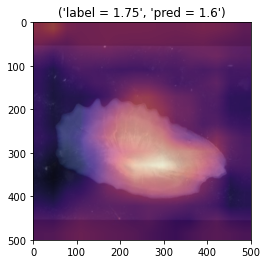

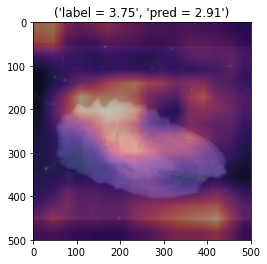

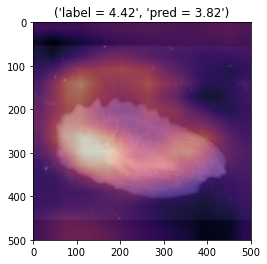

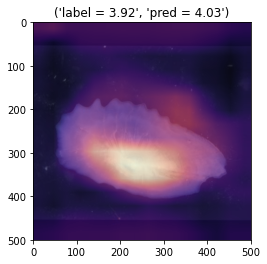

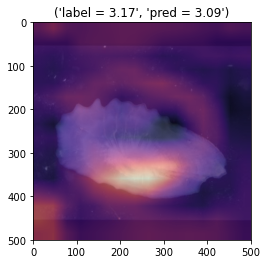

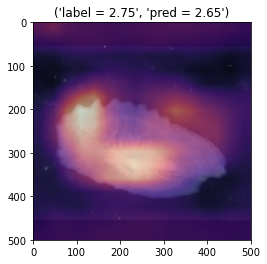

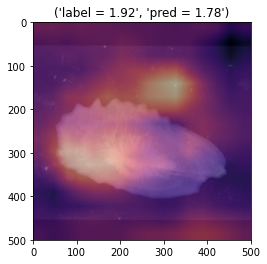

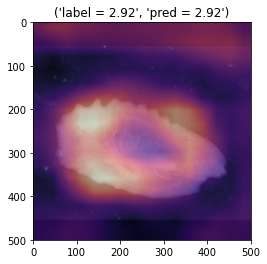

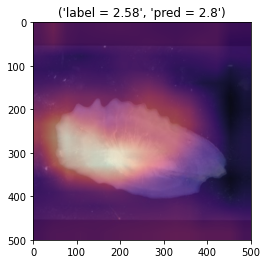

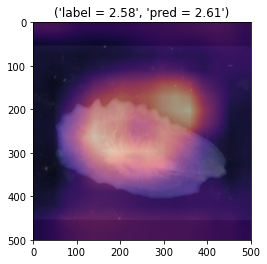

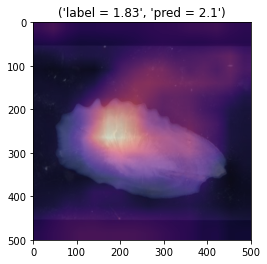

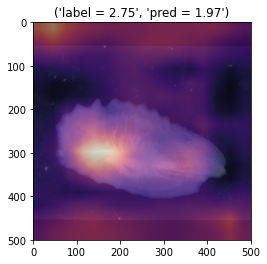

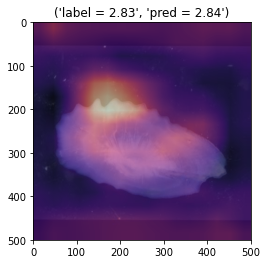

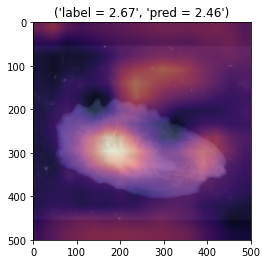

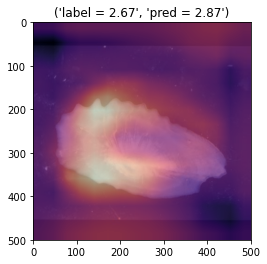

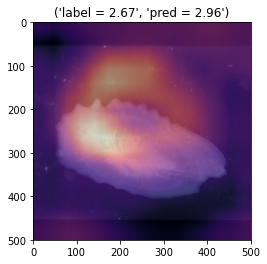

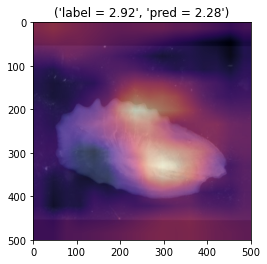

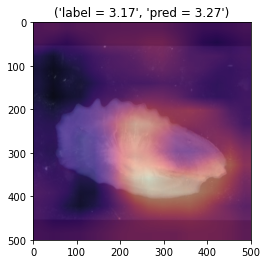

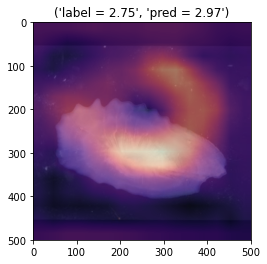

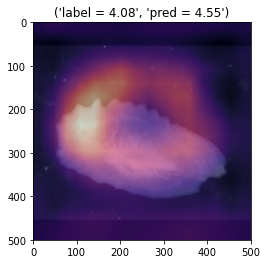

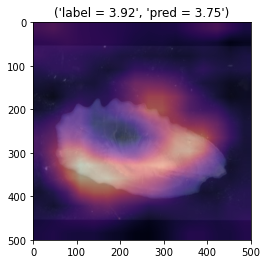

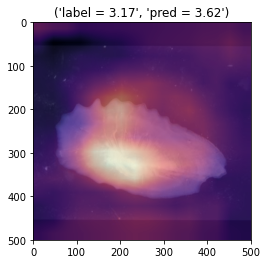

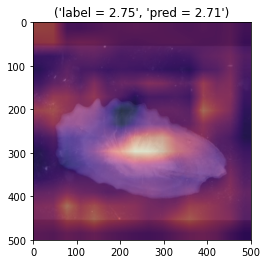

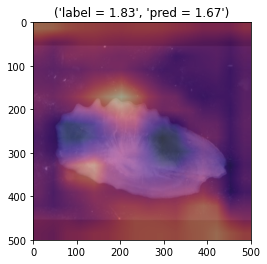

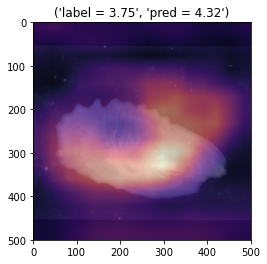

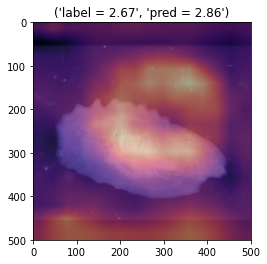

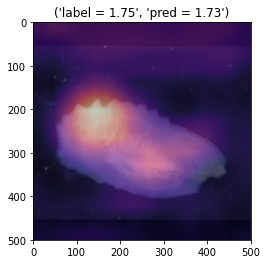

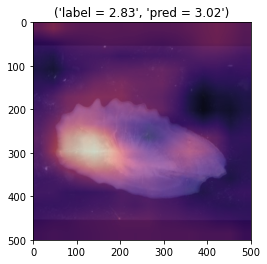

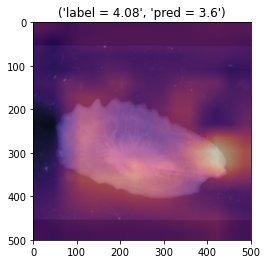

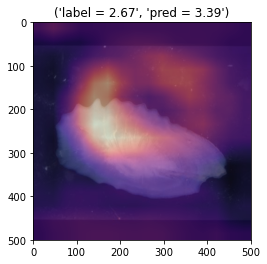

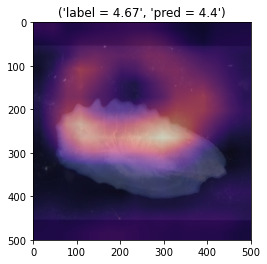

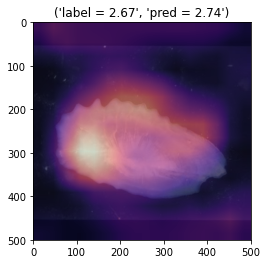

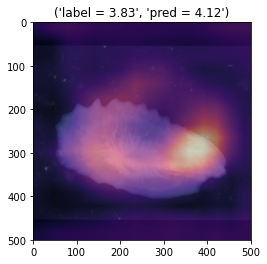

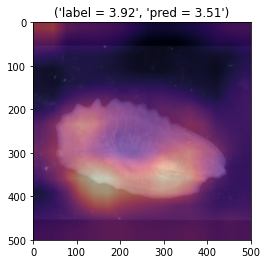

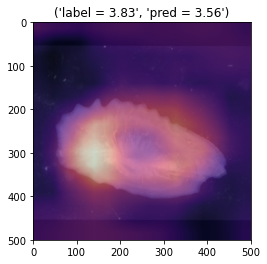

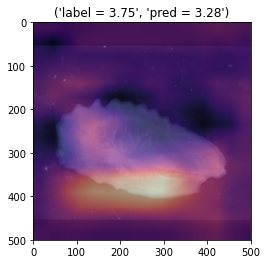

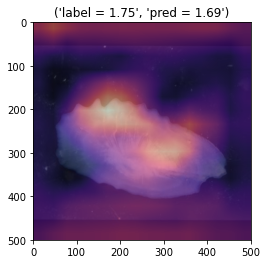

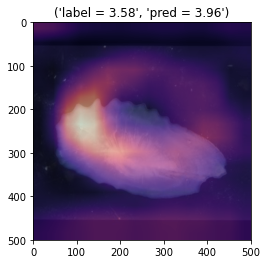

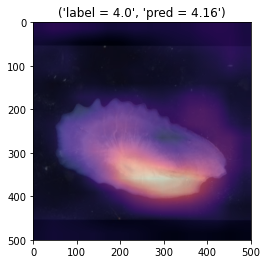

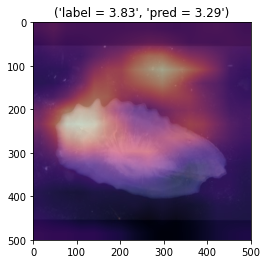

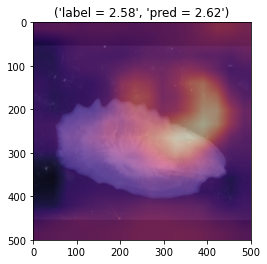

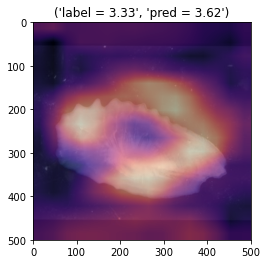

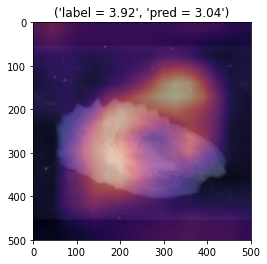

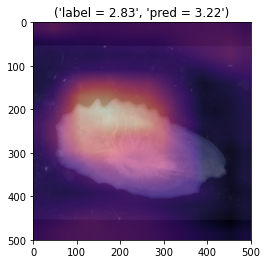

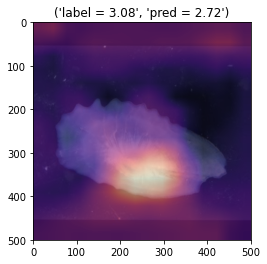

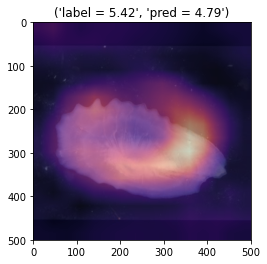

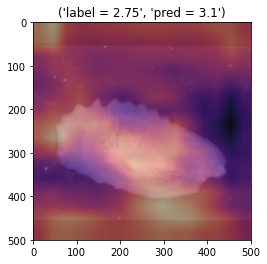

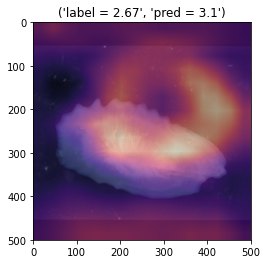

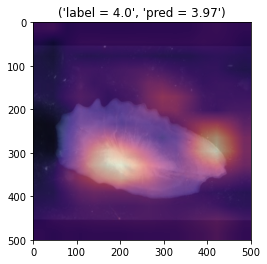

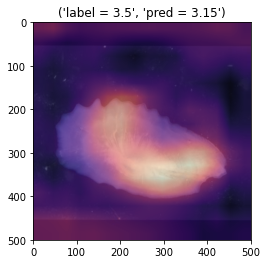

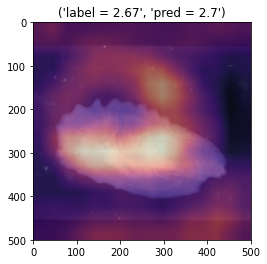

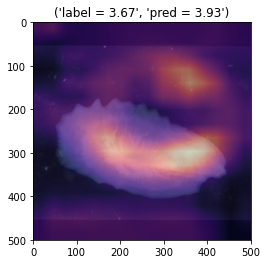

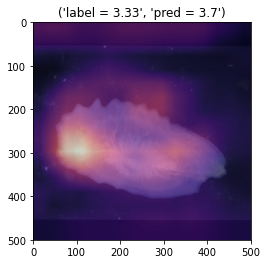

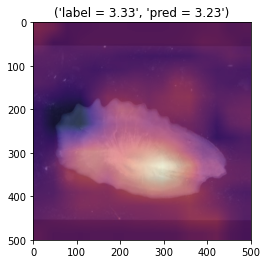

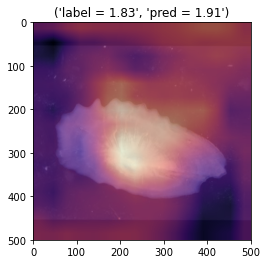

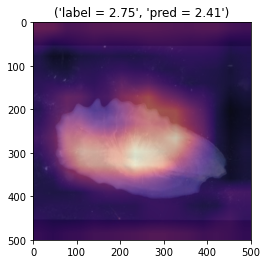

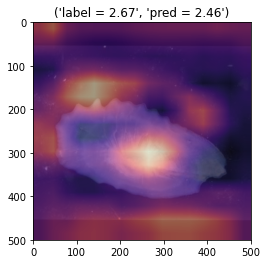

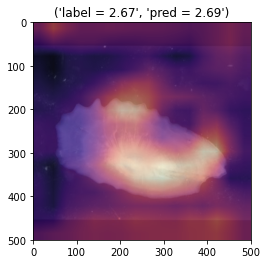

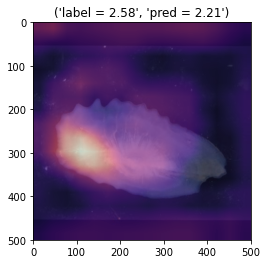

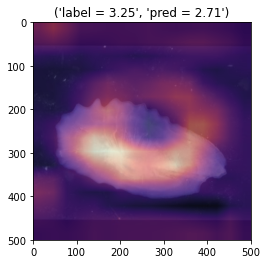

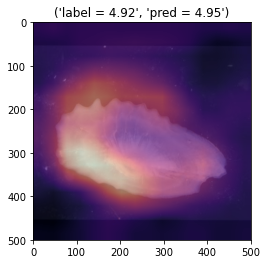

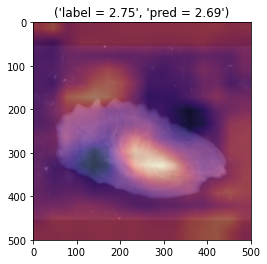

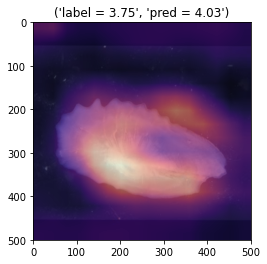

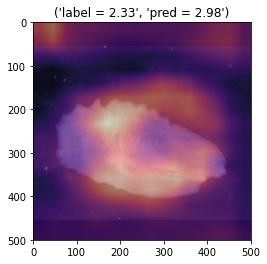

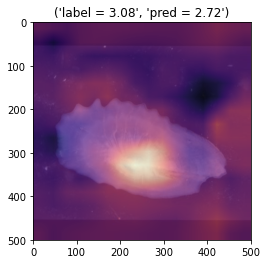

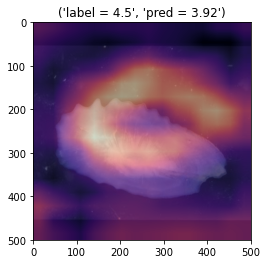

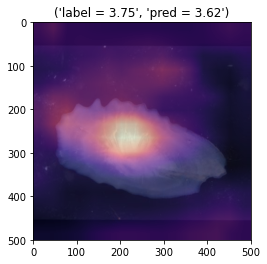

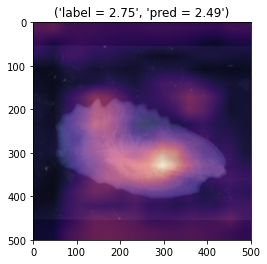

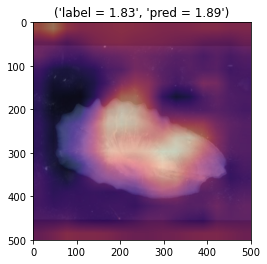

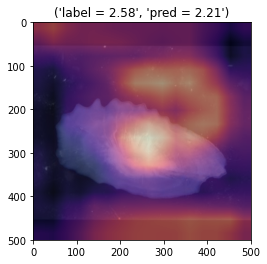

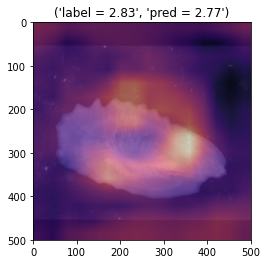

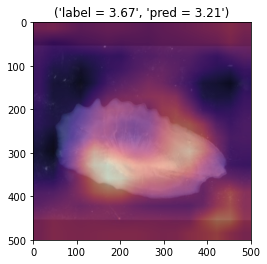

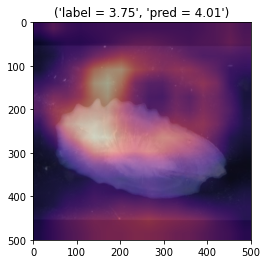

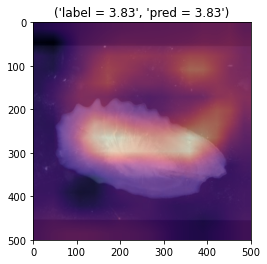

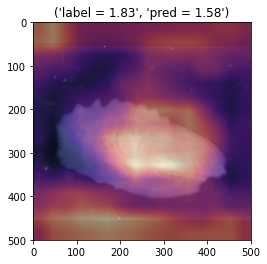

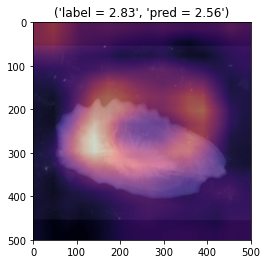

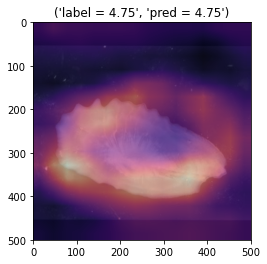

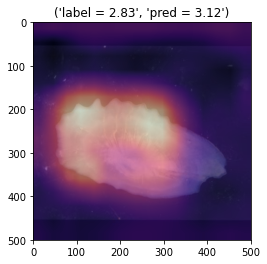

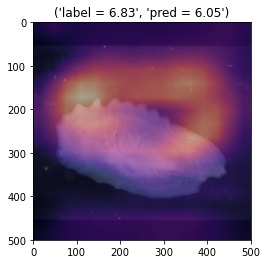

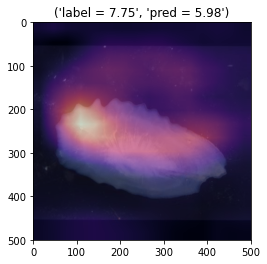

In [18]:
for image_numb in range(0,batch_size):
    _,ax = plt.subplots()
    
    image = batch[0].detach().cpu().numpy()
    image = image-image.min()
    image = (image*(255/image.max())).astype(int)
    image = np.moveaxis(image,0,2)
    pred = str(round(float(output[image_numb].detach().cpu()),2))
    label = str(round(float(labels[image_numb].detach().cpu()),2))
    ax.imshow(image)
    ax.set_title(('label = ' + label,'pred = '+pred))

    
    ax.imshow(cam_map.detach().cpu()[image_numb], alpha=0.6, extent=(0,img_size,img_size,0),
                      interpolation='bilinear', cmap='magma');